In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

In [3]:
spc_dataset_path='E:/azize/Yazilim/Bootcamp/spectrograms/'
metadata=pd.read_csv('E:/azize/Yazilim/Bootcamp/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
def load_images(filename):
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)  # grayscale, resize ve normalizasyon için fonksiyon
    image_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  # OpenCV ile dosya okuma ve grayscale dönüşümü
    image_resize = cv2.resize(image_gray,(400,300),interpolation = cv2.INTER_AREA)   # OpenCV ile resize oluşturma
    image_normal = np.array(image_resize)/255                   # grayscale görüntü normalizasyonu
    image_normal = np.mean(image_normal, axis = 1)
    return image_normal



In [5]:
img_features = []
for index_num,row in tqdm(metadata.iterrows()):     # metadata dosyasının içerisinde sırasıyla gezinmek için for döngüsü
    file_name = os.path.join(os.path.abspath(spc_dataset_path),str(row["classID"])+"/",str(row["slice_file_name"])).split(".wav")[0]+".png"    # metadata dosyası içerisinde kolonları kullanarak görüntü dosyası değişkenini oluşturma
 
    class_labels = row["class"]                 # metadata dosyası içerisinde class kolonunu kullanarak file_name dosyasının karşılık geldiği class değişkenini oluşturma 
    data = load_images(file_name)                     # file_name değişkenini kullanarak her bir load_images fonksiyonuna göre okuma - grayscale, resize ve normalizasyon
    img_features.append([data,class_labels])  # okunan her dosyayı class ile birlikte bir listeye atamak

8732it [03:25, 42.54it/s]


In [6]:
img_features_df = pd.DataFrame(img_features,columns=['feature','class'])  # görüntü (feature) ve etiket (class) formatında liste oluşturma
img_features_df.head()

,feature,class
0,"[0.00980392156862745, 0.00988235294117647, 0.0...",dog_bark
1,"[0.00980392156862745, 0.00988235294117647, 0.0...",children_playing
2,"[0.00980392156862745, 0.00988235294117647, 0.0...",children_playing
3,"[0.00980392156862745, 0.00988235294117647, 0.0...",children_playing
4,"[0.00980392156862745, 0.00988235294117647, 0.0...",children_playing


In [7]:
#  CNN Model ile verisetini eğitme

In [8]:
X=np.array(img_features_df['feature'].tolist())   # img_features_df araryi input (x = feature) ve (y = class) output olara bölme işlemi
y=np.array(img_features_df['class'].tolist())

In [9]:
X.shape

(8732, 300)

In [10]:
y.shape

(8732,)

In [11]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [12]:
labelencoder=LabelEncoder()          # y arrayi kad formatına getirmek
y=to_categorical(labelencoder.fit_transform(y))

In [13]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)   # verisetini hazırlama işlemi

In [15]:
# İLK MODEL 

In [16]:
num_labels = 10  # output için 10 adet karşılaştırma sınıfı var

In [17]:
# İLK MODEL için 3 hiden layer oluşturarak owersizing olmaması için dropout işlemi yapıldı

model=Sequential()
# 1. hidden layer
model.add(Dense(125,input_shape=(300,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2. hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3. hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               37625     
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [19]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [22]:
# İLK MODEL - modeli eğitme- 

epochscount = 300
num_batch_size = 32

results = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)


Epoch 1/300
219/219 [==============================] - 1s 3ms/step - loss: 0.6685 - accuracy: 0.7755 - val_loss: 0.5887 - val_accuracy: 0.8122
Epoch 2/300
219/219 [==============================] - 1s 3ms/step - loss: 0.7014 - accuracy: 0.7634 - val_loss: 0.5699 - val_accuracy: 0.8163
Epoch 3/300
219/219 [==============================] - 1s 3ms/step - loss: 0.6764 - accuracy: 0.7744 - val_loss: 0.5614 - val_accuracy: 0.8163
Epoch 4/300
219/219 [==============================] - 1s 3ms/step - loss: 0.6700 - accuracy: 0.7847 - val_loss: 0.5798 - val_accuracy: 0.8151
Epoch 5/300
219/219 [==============================] - 1s 3ms/step - loss: 0.6802 - accuracy: 0.7761 - val_loss: 0.5619 - val_accuracy: 0.8306
Epoch 6/300
219/219 [==============================] - 1s 3ms/step - loss: 0.6794 - accuracy: 0.7768 - val_loss: 0.5871 - val_accuracy: 0.8145
Epoch 7/300
219/219 [==============================] - 1s 3ms/step - loss: 0.6903 - accuracy: 0.7699 - val_loss: 0.5563 - val_accuracy: 0.8340

In [23]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.8391528129577637


In [24]:
# İKİNCİ MODEL



In [25]:
# İKİNCİ MODEL - 3 hiden layer oluşturarak owersizing olmaması için dropout işlemi yapıldı

model_2=Sequential()
# 1. hidden layer
model_2.add(Dense(250,input_shape=(300,)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
# 2. hidden layer
model_2.add(Dense(200))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
# 3. hidden layer
model_2.add(Dense(300))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))

# output layer
model_2.add(Dense(num_labels))
model_2.add(Activation('softmax'))

In [26]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 250)               75250     
                                                                 
 activation_4 (Activation)   (None, 250)               0         
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               50200     
                                                                 
 activation_5 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 300)              

In [27]:
model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [28]:
# İKİNCİ MODEL - modeli eğitme

epochscount_2 = 400
num_batch_size_2 = 28

results_2 = model_2.fit(X_train, y_train, batch_size=num_batch_size_2, epochs=epochscount_2, validation_data=(X_test, y_test), verbose=1)

Epoch 1/400
250/250 [==============================] - 1s 4ms/step - loss: 1.9714 - accuracy: 0.2712 - val_loss: 1.6837 - val_accuracy: 0.4007
Epoch 2/400
250/250 [==============================] - 1s 3ms/step - loss: 1.6660 - accuracy: 0.3994 - val_loss: 1.4881 - val_accuracy: 0.4745
Epoch 3/400
250/250 [==============================] - 1s 3ms/step - loss: 1.5560 - accuracy: 0.4495 - val_loss: 1.3671 - val_accuracy: 0.5249
Epoch 4/400
250/250 [==============================] - 1s 4ms/step - loss: 1.4916 - accuracy: 0.4739 - val_loss: 1.3540 - val_accuracy: 0.5449
Epoch 5/400
250/250 [==============================] - 1s 3ms/step - loss: 1.4256 - accuracy: 0.4975 - val_loss: 1.3189 - val_accuracy: 0.5535
Epoch 6/400
250/250 [==============================] - 1s 3ms/step - loss: 1.4013 - accuracy: 0.5210 - val_loss: 1.2587 - val_accuracy: 0.5753
Epoch 7/400
250/250 [==============================] - 1s 4ms/step - loss: 1.3499 - accuracy: 0.5399 - val_loss: 1.2031 - val_accuracy: 0.5924

In [29]:
validation_test_set_accuracy_2 = model_2.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy_2[1])

0.8551803231239319


In [30]:
# ÜÇÜNCÜ MODEL

In [31]:
# ÜÇÜNCÜ MODEL - 3 hiden layer oluşturarak owersizing olmaması için dropout işlemi yapıldı

model_3=Sequential()
# 1. hidden layer
model_3.add(Dense(200,input_shape=(300,)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
# 2. hidden layer
model_3.add(Dense(125))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
# 3. hidden layer
model_3.add(Dense(200))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))

# output layer
model_3.add(Dense(num_labels))
model_3.add(Activation('softmax'))

In [32]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 250)               75250     
                                                                 
 activation_4 (Activation)   (None, 250)               0         
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               50200     
                                                                 
 activation_5 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 300)              

In [33]:
model_3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [34]:
# ÜÇÜMCÜ MODEL - modeli eğitme

epochscount_3 = 200
num_batch_size_3 = 34

results_3 = model_3.fit(X_train, y_train, batch_size=num_batch_size_3, epochs=epochscount_3, validation_data=(X_test, y_test), verbose=1)

Epoch 1/200
206/206 [==============================] - 1s 4ms/step - loss: 2.0433 - accuracy: 0.2455 - val_loss: 1.7628 - val_accuracy: 0.3663
Epoch 2/200
206/206 [==============================] - 1s 3ms/step - loss: 1.7698 - accuracy: 0.3485 - val_loss: 1.5887 - val_accuracy: 0.4356
Epoch 3/200
206/206 [==============================] - 1s 3ms/step - loss: 1.6229 - accuracy: 0.4172 - val_loss: 1.4392 - val_accuracy: 0.4957
Epoch 4/200
206/206 [==============================] - 1s 3ms/step - loss: 1.5437 - accuracy: 0.4597 - val_loss: 1.3666 - val_accuracy: 0.4980
Epoch 5/200
206/206 [==============================] - 1s 3ms/step - loss: 1.5004 - accuracy: 0.4702 - val_loss: 1.3320 - val_accuracy: 0.5312
Epoch 6/200
206/206 [==============================] - 1s 3ms/step - loss: 1.4640 - accuracy: 0.4905 - val_loss: 1.3073 - val_accuracy: 0.5438
Epoch 7/200
206/206 [==============================] - 1s 3ms/step - loss: 1.4323 - accuracy: 0.5026 - val_loss: 1.2657 - val_accuracy: 0.5633

In [35]:
validation_test_set_accuracy_3 = model_3.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy_3[1])

0.8128219842910767


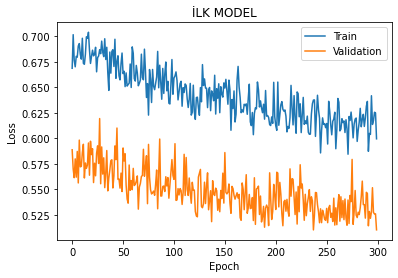

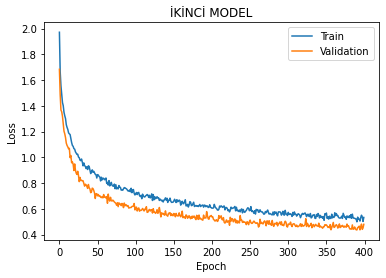

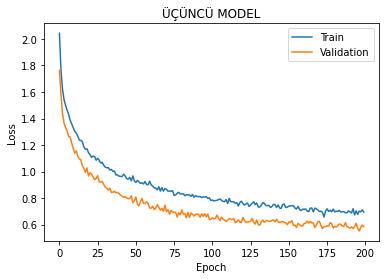

In [36]:
################### İlk model sonucu - results

plt.plot(results.history["loss"], label = "Train" )

plt.plot(results.history["val_loss"], label ="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("İLK MODEL")

# Show the plot
plt.show()


#################### İkinci model sonucu - results_2

plt.plot(results_2.history["loss"], label = "Train" )

plt.plot(results_2.history["val_loss"], label ="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("İKİNCİ MODEL")

# Show the plot
plt.show()


#################### Üçüncü model sonucu - results_3

plt.plot(results_3.history["loss"], label = "Train" )

plt.plot(results_3.history["val_loss"], label ="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("ÜÇÜNCÜ MODEL")

# Show the plot
plt.show()

In [37]:
#   MODELİ SPEKTROGRAM GÖRÜNTÜSÜ ÜZERİNDE TEST AŞAMASI

In [38]:
filename = 'E:/azize/Yazilim/Bootcamp/spectrograms/5/6988-5-0-2.png'
img = cv2.imread(filename, cv2.IMREAD_UNCHANGED) 
image_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
image_resize = cv2.resize(image_gray,(400,300),interpolation = cv2.INTER_AREA)  
image_normal = np.array(image_resize)/255                  
image_normal = np.mean(image_normal, axis = 1)
feature = image_normal.reshape(1,-1)
feature.shape



(1, 300)

In [39]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

In [40]:
# İLK MODEL için test aşaması

result_array = model.predict(feature)
result = np.argmax(result_array[0])
print(result_classes[result]) 


1/1 [==============================] - 0s 122ms/step
engine_idling


In [41]:
# İKİNCİ MODEL için test aşaması

result_array_2 = model_2.predict(feature)
result_2 = np.argmax(result_array_2[0])
print(result_classes[result_2]) 

1/1 [==============================] - 0s 71ms/step
engine_idling


In [42]:
# ÜÇÜNCÜ MODEL için test aşaması

result_array_3 = model_3.predict(feature)
result_3 = np.argmax(result_array_2[0])
print(result_classes[result_3]) 

1/1 [==============================] - 0s 73ms/step
engine_idling
